# Libraries

In [1]:
import math
import random

from itertools import product

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import softmax


np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Settings

In [2]:
K = 10
N_STEPS = 1000
N_TRIALS = 2000

EPSILON = "\u03B5"
ALPHA = "\u03b1"

# History

save data during training

In [3]:
class History:
    
    def __init__(self, n_trials, n_steps, **kwargs):
        self.extra_dim = kwargs.get("extra_dim", 0)
        self.n_trials = n_trials
        self.n_steps = n_steps
        if self.extra_dim != 0:
            self.actions_history = np.zeros(shape=(self.n_trials, self.n_steps, self.extra_dim))
            self.rewards_history = np.full((self.n_trials, self.n_steps, self.extra_dim), np.nan)
        else:
            self.actions_history = np.zeros(shape=(self.n_trials, self.n_steps))
            self.rewards_history = np.full((self.n_trials, self.n_steps), np.nan)
        return None  
    
    def save(self, trial, step, i, reward, action, optimal_action):
        self.rewards_history[trial, step, i] = reward
        if action == optimal_action:
            self.actions_history[trial, step, i] = 100  # %
        return None

# Bandit

In [4]:
class Bandit:
    
    def __init__(self, K, **kwargs):
        self.K = K  # the number of bandit
        self.alpha = kwargs.get("alpha", None)  # use constant step-size parameter instead 1/n[action]
        self.q_init = kwargs.get("q_init", 0)  # see 2.6
        self.c_ucb = kwargs.get("c_ucb", 0)  # UCB degree of exploration, see 2.7
        
        self.t = 0  # the number of times the 'step' function has been called (assume to be reset after each trial)
        self.q = np.full(self.K, self.q_init, dtype=np.float32)  # action value
        self.q_ucb = self.q if self.c_ucb==0 else self.q.copy()  # always equal to 'q' if 'c_ucb' == 0
        self.n = np.zeros(self.K, dtype=np.int32)  # number of times an action is played
        self.q_star = np.random.normal(0, 1, self.K)  # the true values
        self.optimal_action = np.argmax(self.q_star)  # higher reward expectation
        return None
        
    def restart(self):
        """distributions are not affected."""
        self.t = 0
        self.n = np.zeros(self.K)
        self.q = np.full(self.K, self.q_init, dtype=np.float32)
        self.q_ucb = self.q if self.c_ucb==0 else self.q.copy()
        return None
        
    def reset(self):
        self.restart()
        self.q_star = np.random.normal(0, 1, self.K)
        self.optimal_action = np.argmax(self.q_star)
        return None
        
    def computeAction(self, epsilon=0):
        action = np.argmax(self.q_ucb)  # default greedy, remember: q==q_ucb if c_ucb==0
        
        if epsilon != 0:
            u = random.uniform(0, 1)
            if epsilon > u:
                action = random.randint(0, self.K-1)
        return action
      
    def step(self, action):    
        self.t += 1    
        self.n[action] += 1
        reward = random.gauss(self.q_star[action], 1)
        
        if self.alpha:
            self.q[action] += (reward - self.q[action]) * self.alpha
        else:
            self.q[action] += (reward - self.q[action]) / self.n[action]
        
        if self.c_ucb != 0:
            for k in range(self.K):
                self.q_ucb[k] = self.q[k] + self.c_ucb*math.sqrt(math.log(self.t) / self.n[k])
        return reward

### Figure 2.1: distribution

Text(0, 0.5, 'Reward distribution')

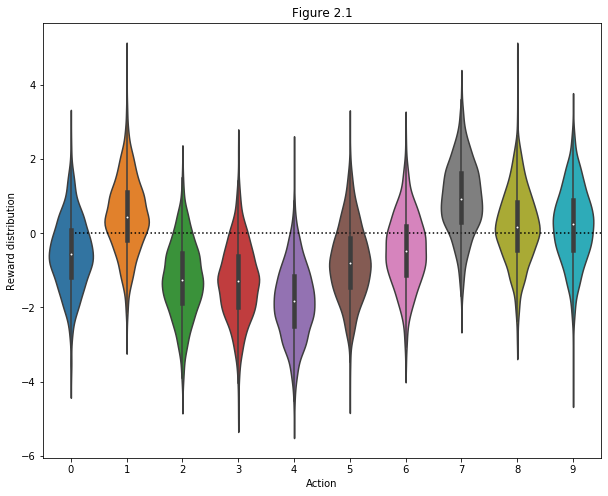

In [5]:
bandits = Bandit(K)
data = np.random.normal(loc=bandits.q_star, scale=1, size=(N_TRIALS, K))

plt.figure(figsize=(10, 8))
plt.title("Figure 2.1")
plt.hlines(y=0, xmin=0, xmax=K, linestyles="dotted")
sns.violinplot(data)
plt.xlabel("Action")
plt.ylabel("Reward distribution")

### Figure 2.2: greedy, epsilon-greedy

In [6]:
ls_epsilons = [0, 0.01, 0.1]
bandits = Bandit(K)
history1 = History(N_TRIALS, N_STEPS, extra_dim=len(ls_epsilons))

for trial in tqdm(range(N_TRIALS)):
    bandits.reset()
    for i, epsilon in enumerate(ls_epsilons):
        bandits.restart()
        for step in range(N_STEPS):
            action = bandits.computeAction(epsilon)
            reward = bandits.step(action)
            history1.save(trial, step, i, reward, action, bandits.optimal_action)

100%|██████████| 2000/2000 [00:32<00:00, 62.14it/s]


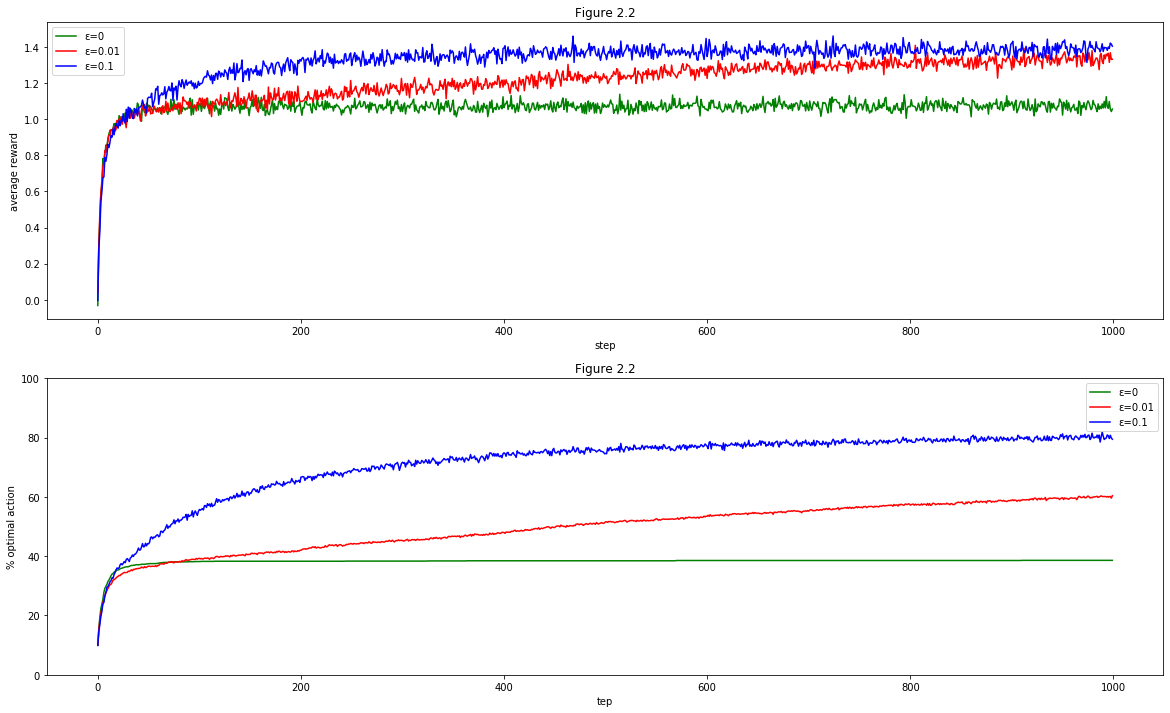

In [7]:
ls_colors = ["green", "red", "blue"]
title = f"Figure 2.2"

f, ax = plt.subplots(2, 1, figsize=(20, 12))
ax[0].set_title(title)
ax[0].set_xlabel("step")
ax[0].set_ylabel("average reward")
for i, epsilon in enumerate(ls_epsilons):
    ax[0].plot(
        history1.rewards_history[:, :, i].mean(0),
        label=f"{EPSILON}={ls_epsilons[i]}",
        c=ls_colors[i]
    )
ax[0].legend()
    
ax[1].set_title(title)
ax[1].set_xlabel("tep")
ax[1].set_ylabel("% optimal action")
for i, epsilon in enumerate(ls_epsilons):
    ax[1].plot(
        history1.actions_history[:, :, i].mean(0),
        label=f"{EPSILON}={ls_epsilons[i]}",
        c=ls_colors[i]
    )
ax[1].set_ylim((0,100))
ax[1].legend();

### Figure 2.3: optimistic

In [8]:
ls_q_init = [0, 5]
history2 = History(N_TRIALS, N_STEPS, extra_dim=len(ls_q_init))

for trial in tqdm(range(N_TRIALS)):
    for i, q_init in enumerate(ls_q_init):
        bandits = Bandit(K, q_init=q_init, alpha=0.1)
        epsilon = 0.1 if q_init==0 else 0
        for step in range(N_STEPS):
            action = bandits.computeAction(epsilon)
            reward = bandits.step(action)
            history2.save(trial, step, i, reward, action, bandits.optimal_action)

100%|██████████| 2000/2000 [00:28<00:00, 69.12it/s]


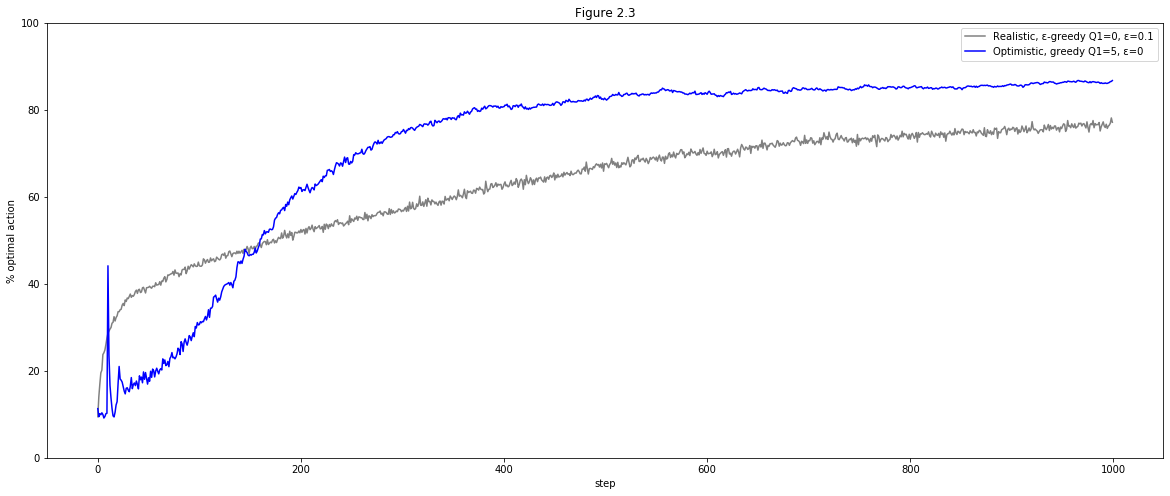

In [9]:
plt.figure(figsize=(20, 8))
plt.title("Figure 2.3")
plt.plot(
    history2.actions_history[:, :, 0].mean(0),
    label=f"Realistic, {EPSILON}-greedy Q1={ls_q_init[0]}, {EPSILON}=0.1",
    c="gray"
)
plt.plot(
    history2.actions_history[:, :, 1].mean(0),
    label=f"Optimistic, greedy Q1={ls_q_init[1]}, {EPSILON}=0",
    c="blue"
)
plt.xlabel("step")
plt.ylabel("% optimal action")
plt.ylim(0, 100)
plt.legend();

### Figure 2.4: upper-confidence-bound (ucb)

In [10]:
ls_c = [0, 2]
history3 = History(N_TRIALS, N_STEPS, extra_dim=len(ls_c))

for trial in tqdm(range(N_TRIALS)):
    for i, c in enumerate(ls_c):
        bandits = Bandit(K, c_ucb=c)
        epsilon = 0 if c != 0 else 0.1
        for step in range(N_STEPS):
            action = bandits.computeAction(epsilon)
            reward = bandits.step(action)
            history3.save(trial, step, i, reward, action, bandits.optimal_action)

100%|██████████| 2000/2000 [01:48<00:00, 18.46it/s]


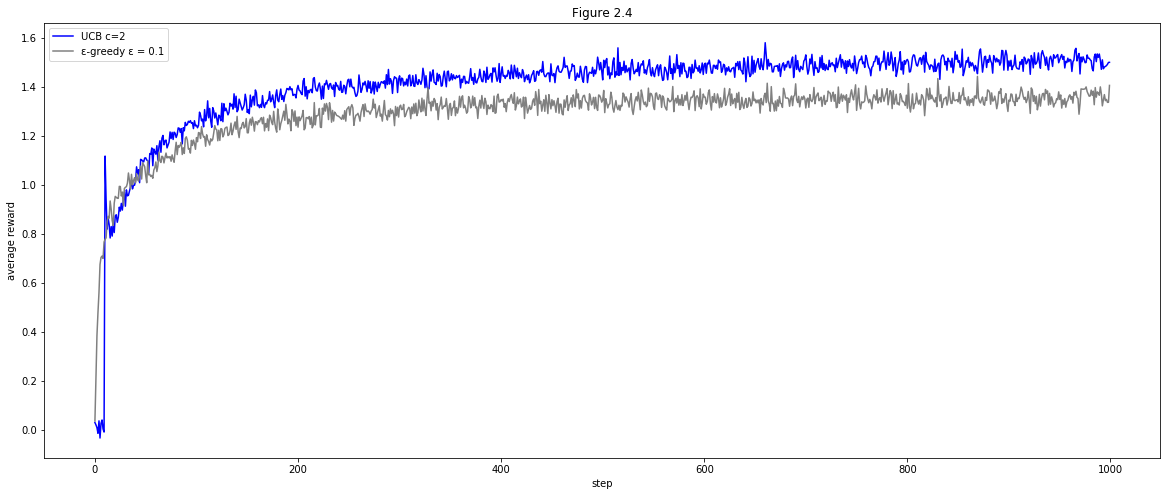

In [11]:
plt.figure(figsize=(20, 8))
plt.title("Figure 2.4")
plt.plot(
    history3.rewards_history[:, :, 1].mean(0),
    label=f"UCB c=2",
    c="blue"
)
plt.plot(
    history3.rewards_history[:, :, 0].mean(0),
    label=f"{EPSILON}-greedy {EPSILON} = 0.1",
    c="gray"
)
plt.xlabel("step")
plt.ylabel("average reward")
plt.legend();

# Gradient Bandit

In [12]:
class GradientBandit:
    
    def __init__(self, K, **kwargs):
        self.K = K  # the number of bandit
        self.alpha = kwargs.get("alpha", 0.1)  # use constant step-size parameter instead 1/n[action]
        self.baseline = kwargs.get("baseline", 0)
        self.mu = kwargs.get("mu", 0)  # the mean of normal distribution
        self.manual_q_star = kwargs.get("manual_q_star", None)  # distribution given outside
        
        self.t = 0  # the number of times the 'step' function has been called (assume to be reset after each trial)
        self.q_star = np.random.normal(self.mu, 1, self.K)  # the true values
        self.reward_bar = self.baseline 
        self.preferences = np.zeros(self.K, dtype=np.float32)  # Ht(a)
        self.proba = np.full(self.K, 1/self.K, dtype=np.float32)
        self.optimal_action = np.argmax(self.q_star)  # higher reward expectation
        
        self.action_space = np.arange(self.K)
        return None
    
    def restart(self):
        """distributions are not affected."""
        self.t = 0
        self.reward_bar = self.baseline 
        self.preferences = np.zeros(self.K, dtype=np.float32)  
        self.proba = np.full(self.K, 1/self.K, dtype=np.float32) 
        return None
        
    def reset(self):
        self.restart()
        self.q_star = np.random.normal(self.mu, 1, self.K)
        self.optimal_action = np.argmax(self.q_star)
        return None
    
    def computeAction(self):
        self.proba /= np.sum(self.proba)  # normalize for sum proba = 1
        action = np.random.choice(self.action_space, p=self.proba)
        return action
    
    def draw(self, action):
        return random.gauss(self.q_star[action], 1)
        
    def step(self, action):    
        self.t += 1    
        reward = self.draw(action)
        self.proba = softmax(self.preferences)
        
        for k in range(self.K):
            if k == action:
                self.preferences[k] = self.preferences[k] + self.alpha*(reward - self.reward_bar) * (1 - self.proba[k])
            else:
                self.preferences[k] = self.preferences[k] - self.alpha*(reward - self.reward_bar) * self.proba[k]
        if self.baseline != 0:
            self.reward_bar += (reward - self.reward_bar) / self.t
        return reward

### Figure 2.5: baseline

In [13]:
MU = 4
ls_baselines = [0, 4]
ls_alphas = [0.1, 0.4]
ls_baselines_alphas = list(product(ls_baselines, ls_alphas))
history4 = History(N_TRIALS, N_STEPS, extra_dim=len(ls_baselines_alphas))

for trial in tqdm(range(N_TRIALS)):
    for i, (baseline, alpha) in enumerate(ls_baselines_alphas):
        gradient_bandits = GradientBandit(K, baseline=baseline, alpha=alpha, mu=MU)
        for step in range(N_STEPS):
            action = gradient_bandits.computeAction()
            reward = gradient_bandits.step(action)
            history4.save(trial, step, i, reward, action, gradient_bandits.optimal_action) 

100%|██████████| 2000/2000 [08:08<00:00,  4.09it/s]


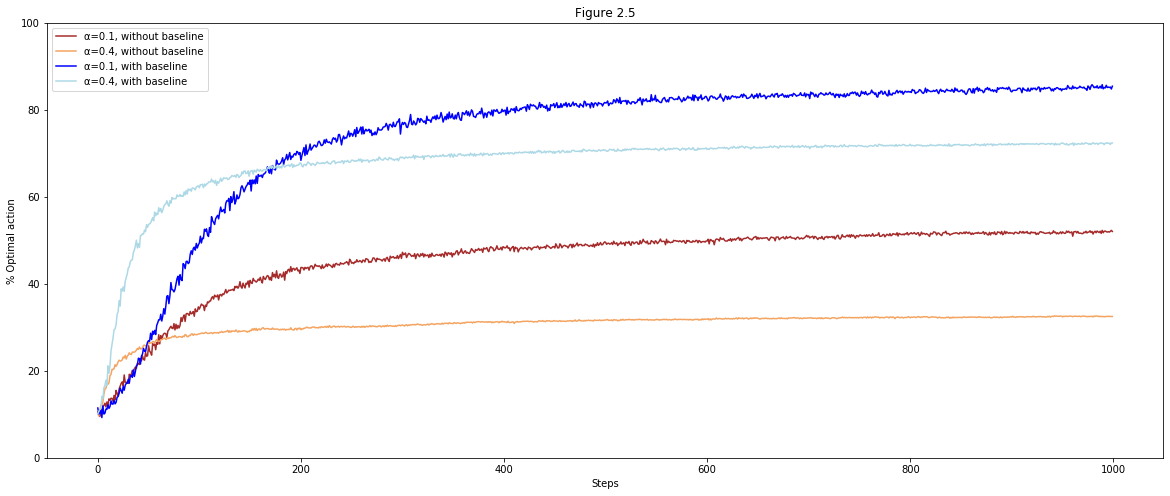

In [14]:
ls_colors = ["brown", "sandybrown", "blue", "lightblue"]
plt.figure(figsize=(20, 8))
plt.title(f"Figure 2.5")
for i in range(len(ls_baselines_alphas)):
    baseline, alpha = ls_baselines_alphas[i]
    lab = f"{ALPHA}={alpha}, without baseline" if baseline == 0 else f"{ALPHA}={alpha}, with baseline"
    plt.plot(
        history4.actions_history[:, :, i].mean(0),
        label=lab,
        c=ls_colors[i]
    )
plt.ylim(0, 100)
plt.xlabel("Steps")
plt.ylabel("% Optimal action")
plt.legend();

# Summary

### Figure 2.6: parameter study

In [15]:
def study(n_trials, n_steps, bandit, epsilon=0):
    tab = np.zeros(n_trials, dtype=np.float32)
    for trial in range(n_trials):
        reward = 0
        bandit.reset()  
        for _ in range(n_steps):
            if isinstance(bandit, Bandit):
                action = bandit.computeAction(epsilon)
            elif isinstance(bandit, GradientBandit):
                action = bandit.computeAction()
            else:
                raise TypeError(f"expected type 'Bandit' or 'GradientBandit' for parameter 'bandit', get type {bandit} instead.")
            reward += bandit.step(action)
        tab[trial] = reward / n_steps
    return tab

In [16]:
ls_epsilons = [1/128, 1/64, 1/32, 1/16, 1/8, 1/4]
ls_alphas = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4]
ls_c_ucb = [1/16, 1/8, 1/4, 1/2, 1, 2, 4]
ls_q0s = [1/4, 1/2, 1, 2, 4]

ay_epsilon = np.zeros(shape=(len(ls_epsilons), N_TRIALS))
ay_alpha = np.zeros(shape=(len(ls_alphas), N_TRIALS))
ay_c_ucb = np.zeros(shape=(len(ls_c_ucb), N_TRIALS))
ay_q0 = np.zeros(shape=(len(ls_q0s), N_TRIALS))

##### espilon

In [17]:
for i, epsilon in enumerate(tqdm(ls_epsilons)): 
    bandits_epsilon = Bandit(K)
    ay_epsilon[i] = study(n_trials=N_TRIALS, n_steps=N_STEPS, bandit=bandits_epsilon, epsilon=epsilon)

100%|██████████| 6/6 [00:51<00:00,  8.61s/it]


##### alpha

In [18]:
for i, alpha in enumerate(tqdm(ls_alphas)):
    gradient_bandits = GradientBandit(K, alpha=alpha, mu=0)
    ay_alpha[i] = study(n_trials=N_TRIALS, n_steps=N_STEPS, bandit=gradient_bandits)

100%|██████████| 8/8 [14:55<00:00, 111.95s/it]


##### c_ucb

In [19]:
for i, c_ucb in enumerate(tqdm(ls_c_ucb)):
    bandits_ucb = Bandit(K, c_ucb=c_ucb)
    ay_c_ucb[i] = study(n_trials=N_TRIALS, n_steps=N_STEPS, bandit=bandits_ucb)

100%|██████████| 7/7 [05:07<00:00, 43.90s/it]


##### q0

In [20]:
for i, q0 in enumerate(tqdm(ls_q0s)):
    bandits_q0 = Bandit(K, alpha=0.1, q_init=q0)
    ay_q0[i] = study(n_trials=N_TRIALS, n_steps=N_STEPS, bandit=bandits_q0)

100%|██████████| 5/5 [00:40<00:00,  8.04s/it]


In [21]:
idx = sorted(list(set(ls_epsilons + ls_alphas + ls_c_ucb + ls_q0s)))
df = pd.DataFrame(index=idx, columns=[f"{ALPHA}", "UCB", f"{EPSILON}", "Q0"])
df.loc[ls_alphas, f"{ALPHA}"] = ay_alpha.mean(1)
df.loc[ls_c_ucb, "UCB"] = ay_c_ucb.mean(1)
df.loc[ls_epsilons, f"{EPSILON}"] = ay_epsilon.mean(1)
df.loc[ls_q0s, "Q0"] = ay_q0.mean(1)
df

,α,UCB,ε,Q0
0.007812,NaN,NaN,1.172134,NaN
0.015625,NaN,NaN,1.24502,NaN
0.031250,1.093825,NaN,1.310992,NaN
0.062500,1.281797,1.435655,1.340585,NaN
0.125000,1.369849,1.435381,1.264782,NaN
0.250000,1.422805,1.444825,1.1122,1.32342
0.500000,1.344733,1.472668,NaN,1.405571
1.000000,1.292152,1.484956,NaN,1.457394
2.000000,1.114664,1.381633,NaN,1.439343
4.000000,0.943772,1.178362,NaN,1.302374


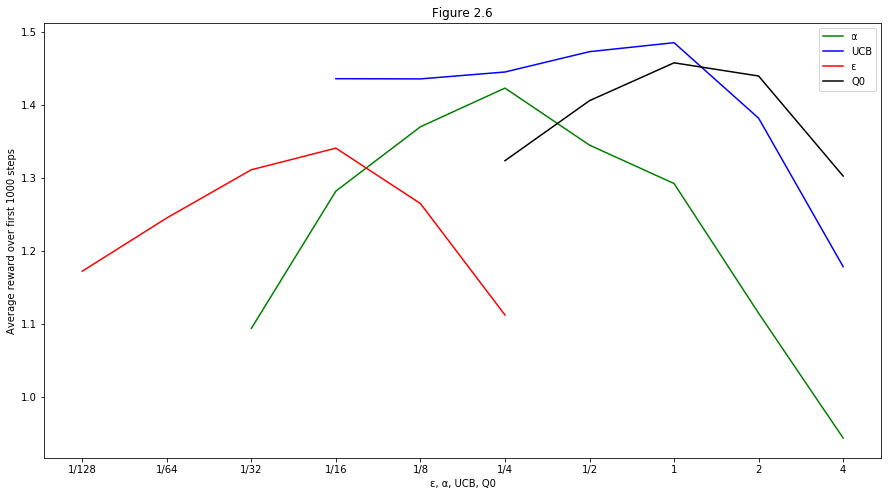

In [22]:
ticks = sorted(list(set(ls_epsilons + ls_alphas + ls_c_ucb + ls_q0s)))
ticks = [f"1/{int(1/2**e)}" for e in range(-7, 0, 1)] + ["1", "2", "4"]
ls_colors = ["green", "blue", "red", "black"]

plt.figure(figsize=(15, 8))
plt.title("Figure 2.6")
plt.xticks(np.arange(len(ticks)), ticks)
for i, c in enumerate(df.columns):
    plt.plot(df[c].values, label=c, c=ls_colors[i])
plt.xlabel(f"{df.columns[2]}, {df.columns[0]}, {df.columns[1]}, {df.columns[3]}")
plt.ylabel("Average reward over first 1000 steps")
plt.legend();